# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The main steps in this notebook are:

1. Install custom libraries
2. Load the data
3. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature
4. Train machine learning models using `Scikit-Learn` and `LightGBM`, and track experiments using MLflow and Fabric Autologging feature
5. Evaluate and save the final machine learning model
6. Demonstrate the model performance via visualizations in Power BI


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Install custom libraries


When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install a custom library (e.g., `imblearn` in this notebook) for the Apache Spark session. To do this, you have two choices. 

1. You can use the in-line installation capabilities (e.g., `%pip`, `%conda`, etc.) to quickly get started with new libraries. Note that this installation option would install the custom libraries only in the current notebook and not in the workspace.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).

For this notebook, you'll install the `imblearn` using `%pip install`. Note that the PySpark kernel will be restarted after `%pip install`, thus you'll need to install the library before you run any other cells.

In [ ]:
# Use pip to install imblearn for SMOTE
%pip install imblearn

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 34, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-6fe11b99-7ced-420d-9b66-c698fe698c09/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the data

### Dataset

The dataset in *churn.csv* contains the churn status of 10,000 customers, along with 14 attributes that include:

- Credit score
- Geographical location (Germany, France, Spain)
- Gender (male, female)
- Age
 Tenure (number of years the person was a customer at that bank)
- Account balance
- Estimated salary
- Number of products that a customer purchased through the bank
- Credit card status (whether or not the customer has a credit card)
- Active member status (whether or not the person is an active bank customer)

The dataset also includes row number, customer ID, and customer surname columns. Values in these columns shouldn't influence a customer's decision to leave the bank.

A customer bank account closure event defines the churn for that customer. The dataset `Exited` column refers to the customer's abandonment. Since we have little context about these attributes, we don't need background information about the dataset. We want to understand how these attributes contribute to the `Exited` status.

Out of those 10,000 customers, only 2037 customers (roughly 20%) left the bank. Because of the class imbalance ratio, we recommend generation of synthetic data. Confusion matrix accuracy might not have relevance for imbalanced classification. We might want to measure the accuracy using the Area Under the Precision-Recall Curve (AUPRC).

- This table shows a preview of the `churn.csv` data:

|CustomerID|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|

### Download dataset and upload to lakehouse

Define these parameters, so that you can use this notebook with different datasets:

In [ ]:
IS_CUSTOM_DATA = False  # If TRUE, the dataset has to be uploaded manually

IS_SAMPLE = False  # If TRUE, use only SAMPLE_ROWS of data for training; otherwise, use all data
SAMPLE_ROWS = 5000  # If IS_SAMPLE is TRUE, use only this number of rows for training


DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/churn"  # Folder with data files
DATA_FILE = "churn.csv"  # Data file name

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 36, Finished, Available)



This code downloads a publicly available version of the dataset, and then stores that dataset in a Fabric lakehouse:

> [!IMPORTANT]
> [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before you run it. Failure to do so will result in an error.

In [ ]:
import os, requests
if not IS_CUSTOM_DATA:
# With an Azure Synapse Analytics blob, this can be done in one line

#  Download demo data files into the lakehouse if they don't exist
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn"
    file_list = ["churn.csv"]
    download_path = "/lakehouse/default/Files/churn/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 37, Finished, Available)

Downloaded demo data files into lakehouse.


Start recording the time needed to run the notebook:

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 38, Finished, Available)

### Read raw data from the lakehouse

This code reads raw data from the **Files** section of the lakehouse, and adds more columns for different date parts. Creation of the partitioned delta table uses this information.

In [ ]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("Files/churn/raw/churn.csv")
    .cache()
)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 39, Finished, Available)

### Create a pandas DataFrame from the dataset

This code converts the Spark DataFrame to a pandas DataFrame, for easier processing and visualization:

In [ ]:
df = df.toPandas()

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 40, Finished, Available)

## Step 3: Perform exploratory data analysis

### Display raw data

Explore the raw data with `display`, calculate some basic statistics, and show chart views. You must first import the required libraries for data visualization - for example, [seaborn](https://seaborn.pydata.org/). Seaborn is a Python data visualization library, and it provides a high-level interface to build visuals on dataframes and arrays.

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 41, Finished, Available)

In [ ]:
display(df, summary=True)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 42, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 80cdf300-f868-4c74-a5e2-347e3b0c6547)

### Use Data Wrangler to perform initial data cleansing

Launch Data Wrangler directly from the notebook to explore and transform pandas dataframes. At the notebook ribbon **Data** tab, use the Data Wrangler dropdown prompt to browse the activated pandas DataFrames available for editing. Select the DataFrame you want to open in Data Wrangler.

> [!NOTE]
> Data Wrangler cannot be opened while the notebook kernel is busy. The cell execution must finish before you launch Data Wrangler. [Learn more about Data Wrangler](https://aka.ms/fabric/datawrangler).

<br>

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/select_datawrangler.png"  width="40%" height="10%" title="Screenshot shows where to access the Data Wrangler.">

After the Data Wrangler launches, a descriptive overview of the data panel is generated, as shown in the following images. The overview includes information about the dimension of the DataFrame, any missing values, etc. You can use Data Wrangler to generate the script to drop the rows with missing values, the duplicate rows and the columns with specific names. Then, you can copy the script into a cell. The next cell shows that copied script.

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/menu_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler menu."> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/missing_data_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler missing data display.">



In [ ]:
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    df.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 43, Finished, Available)

In [ ]:
# if IS_SAMPLE is True, use only SAMPLE_ROWS of rows for training
if IS_SAMPLE:
    df_clean = df_clean.limit(SAMPLE_ROWS)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 44, Finished, Available)

### Determine attributes

This code determines the categorical, numerical, and target attributes:

In [ ]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print(dependent_variable_name)
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if col in "O"
                        or df_clean[col].nunique() <=5
                        and col not in "Exited"]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 45, Finished, Available)

Exited
['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


### Show the five-number summary

Show the five-number summary (minimum score, first quartile, median, third quartile, and maximum score) for the numerical attributes by using box plots:

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 46, Finished, Available)

/tmp/ipykernel_4067/2095287195.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


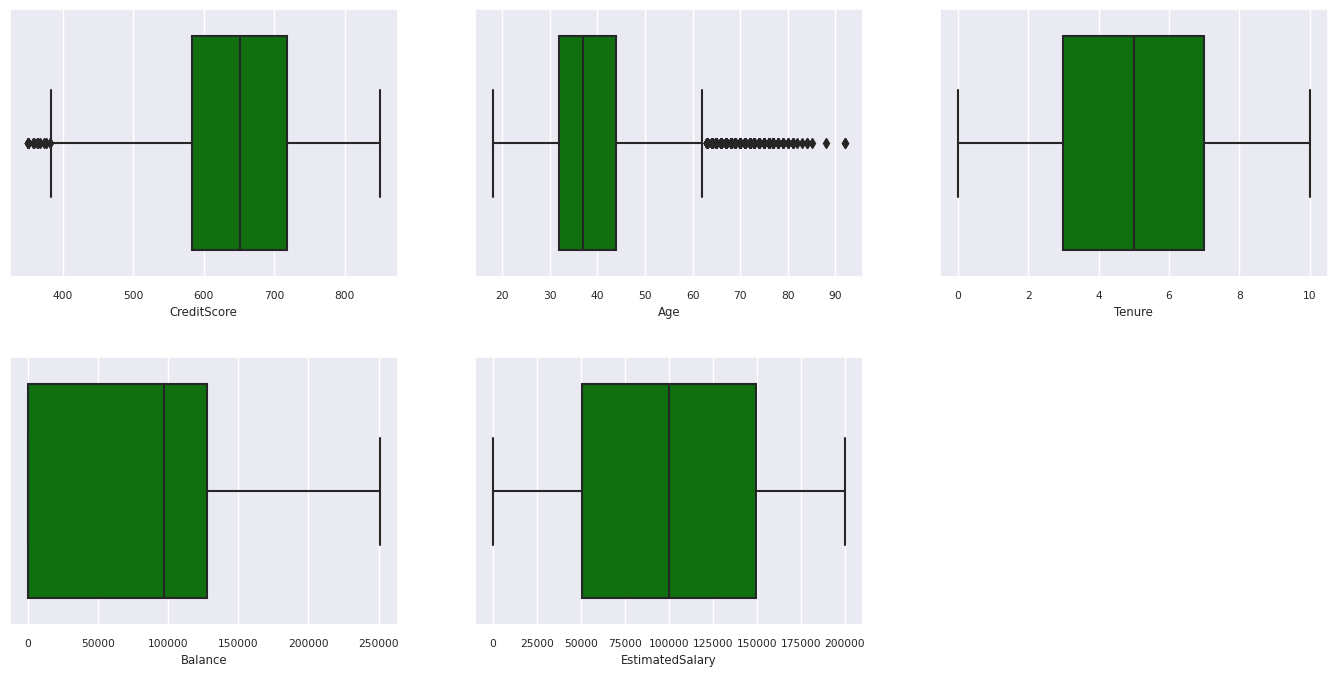

In [ ]:
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale = 0.7) 
fig, axes = plt.subplots(nrows = 2, ncols = 3, gridspec_kw =  dict(hspace=0.3), figsize = (17,8))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
# fig.suptitle('visualize and compare the distribution and central tendency of numerical attributes', color = 'k', fontsize = 12)
fig.delaxes(axes[1,2])


Show the distribution of exited versus non-exited customers across the categorical attributes:

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 47, Finished, Available)

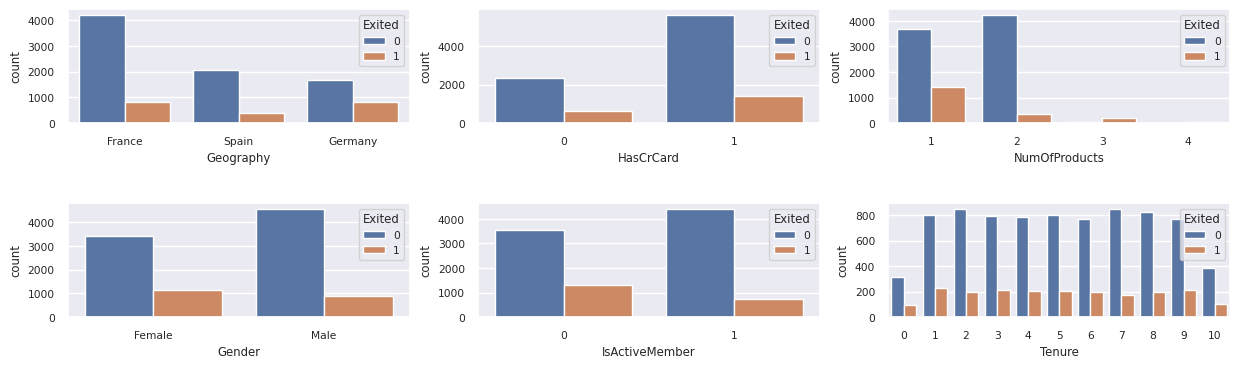

In [ ]:
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate (attr_list):
    sns.countplot(x = item, hue = 'Exited', data = df_clean, ax = axarr[ind%2][ind//2])
fig.subplots_adjust(hspace=0.7)

Use a histogram to show the frequency distribution of numerical attributes:

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 48, Finished, Available)

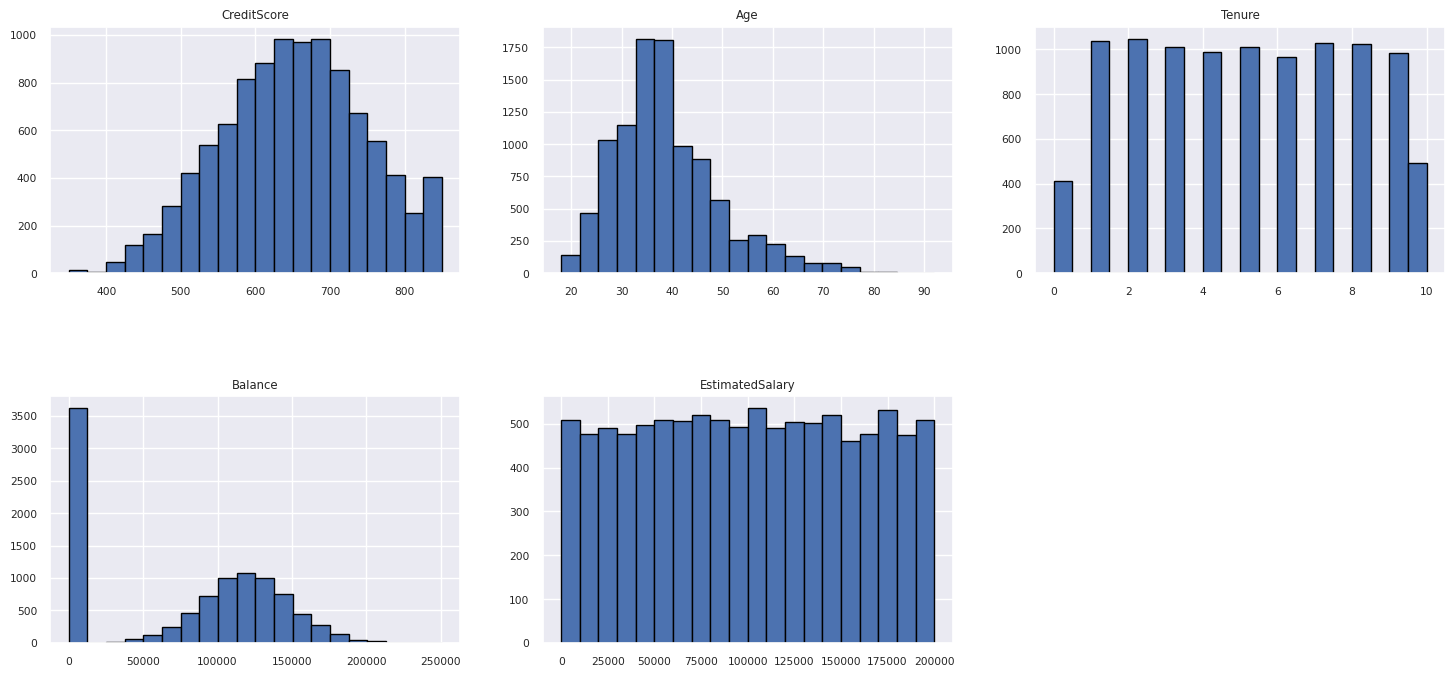

In [ ]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)
# fig = fig.suptitle('distribution of numerical attributes', color = 'r' ,fontsize = 14)
plt.show()

### Perform feature engineering 

This feature engineering generates new attributes based on the current attributes:

In [ ]:
df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 49, Finished, Available)

### Use Data Wrangler to perform one-hot encoding

With the same steps to launch Data Wrangler, as discussed earlier, use the Data Wrangler to perform one-hot encoding. This cell shows the copied generated script for one-hot encoding:

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows one-hot encoding in the Data Wrangler"> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_selectcolumns_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows selection of columns in the Data Wrangler.">





In [ ]:
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 50, Finished, Available)

### Create a delta table to generate the Power BI report

In [ ]:
table_name = "df_clean"
# Create a PySpark DataFrame from pandas
sparkDF=spark.createDataFrame(df_clean) 
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark DataFrame saved to delta table: {table_name}")

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 51, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:425: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion from Arrow: uint8
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Spark dataframe saved to delta table: df_clean


### Summary of observations from the exploratory data analysis

- Most of the customers are from France. Spain has the lowest churn rate, compared to France and Germany.
- Most of the customers have credit cards.
- Some customers are both over the age of 60 and have credit scores below 400. However, they can't be considered as outliers
- Very few customers have more than two of the bank's products.
- Inactive customers have a higher churn rate
- Gender and tenure years have little impact on a customer's decision to close a bank account


## Step 4: Model training and tracking


With the data in place, you can now define the model. Apply random forest and LightGBM models in this notebook.

Use the scikit-learn and LightGBM libraries to implement the models, with a few lines of code. Additionally, use MLfLow and Fabric Autologging to track the experiments.

This code sample loads the delta table from the lakehouse. You can use other delta tables that themselves use the lakehouse as the source.

In [ ]:
SEED = 12345
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 52, Finished, Available)

### Generate an experiment for tracking and logging the models by using MLflow\

This section shows how to generate an experiment, and it specifies the model and training parameters and the scoring metrics. Additionally, it shows how to train the models, log them, and save the trained models for later use.

In [ ]:
import mlflow

# Set up the experiment name
EXPERIMENT_NAME = "sample-bank-churn-experiment"  # Mlflow  experiment name

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 53, Finished, Available)

Autologging automatically captures both the input parameter values and the output metrics of a machine learning model, as that model is trained. This information is then logged to your workspace, where the MLflow APIs or the corresponding experiment in your workspace can access and visualize it.

When complete, your experiment resembles this image:

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/experiment_runs.png"  width="70%" height="10%" title="Screenshot shows the experiment page for the bank-churn-experiment.">

All the experiments with their respective names are logged, and you can track their parameters and performance metrics. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).


### Set experiment and autologging specifications


In [ ]:
mlflow.set_experiment(EXPERIMENT_NAME) # Use a date stamp to append to the experiment
mlflow.autolog(exclusive=False)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 54, Finished, Available)

2023/09/05 17:08:03 INFO mlflow.tracking.fluent: Experiment with name 'sample-bank-churn-experiment' does not exist. Creating a new experiment.
2023/09/05 17:08:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/09/05 17:08:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


### Import scikit-learn and LightGBM

In [ ]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 55, Finished, Available)

2023/09/05 17:08:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/09/05 17:08:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Prepare training and test datasets

In [ ]:
y = df_clean["Exited"]
X = df_clean.drop("Exited",axis=1)
# Train/test separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 56, Finished, Available)

### Apply SMOTE to the training data

Imbalanced classification has a problem, because it has too few examples of the minority class for a model to effectively learn the decision boundary. To handle this, Synthetic Minority Oversampling Technique (SMOTE) is the most widely used technique to synthesize new samples for the minority class. Access SMOTE with the `imblearn` library that you installed in step 1.

Apply SMOTE only to the training dataset. You must leave the test dataset in its original imbalanced distribution, to get a valid approximation of model performance on the original data. This experiment represents the situation in production.

For more information, see [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [From random over-sampling to SMOTE and ADASYN](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn). The imbalanced-learn website hosts these resources.

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 57, Finished, Available)

2023/09/05 17:08:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a562e830-65cb-4325-8a6c-9c308ada3b60', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/05 17:08:14 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/05 17:08:14 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/05 17:08:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/09/05 17:08:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/_

### Train the model

Use Random Forest to train the model, with a maximum depth of four, and with four features:

In [ ]:
mlflow.sklearn.autolog(registered_model_name='rfc1_sm')  # Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    # rfc1.fit(X_train,y_train) # Imbalanaced training data
    rfc1_sm.fit(X_res, y_res.ravel()) # Balanced training data
    rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 58, Finished, Available)

run_id: 0cde1159-b297-4969-a3a9-03ae067343ef; status: RUNNING


2023/09/05 17:08:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Successfully registered model 'rfc1_sm'.
2023/09/05 17:08:27 INFO mlflow.tracking._model_registry.client: Waiting up

Use Random Forest to train the model, with a maximum depth of eight, and with six features:

In [ ]:
mlflow.sklearn.autolog(registered_model_name='rfc2_sm')  # Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    # rfc2.fit(X_train,y_train) # Imbalanced training data
    rfc2_sm.fit(X_res, y_res.ravel()) # Balanced training data
    rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 59, Finished, Available)

run_id: dc8f5ee0-b2a1-4dc4-96e6-48896b4de147; status: RUNNING


2023/09/05 17:08:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Successfully registered model 'rfc2_sm'.
2023/09/05 17:08:42 INFO mlflow.tracking._model_registry.client: Waiting up

Train the model with LightGBM:

In [ ]:
# lgbm_model
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm')  # Register the trained model with autologging
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07, 
                        max_delta_step = 2, 
                        n_estimators = 100,
                        max_depth = 10, 
                        eval_metric = "logloss", 
                        objective='binary', 
                        random_state=42)

with mlflow.start_run(run_name="lgbm_sm") as run:
    lgbm1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    # lgbm_sm_model.fit(X_train,y_train) # Imbalanced training data
    lgbm_sm_model.fit(X_res, y_res.ravel()) # Balanced training data
    y_pred = lgbm_sm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr_lgbm_sm = classification_report(y_test, y_pred)
    cm_lgbm_sm = confusion_matrix(y_test, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_res, lgbm_sm_model.predict_proba(X_res)[:, 1])

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 60, Finished, Available)

[LightGBM] [Warning] Unknown parameter: eval_metric


2023/09/05 17:08:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Successfully registered model 'lgbm_sm'.
2023/09/05 17:08:52 INFO mlflow.tracking._model_registry.client: Waiting up

### View the experiment artifact to track model performance

The experiment runs are automatically saved in the experiment artifact. You can find that artifact in the workspace. An artifact name is based on the name used to set the experiment. All of the trained models, their runs, performance metrics and model parameters are logged on the experiment page.

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case, **sample-bank-churn-experiment**.

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/experiment_runs.png"  width="400%" height="100%" title="Screenshot shows logged values for one of the models.">

## Step 5: Evaluate and save the final machine learning model


Open the saved experiment from the workspace to select and save the best model.

In [ ]:
# Define run_uri to fetch the model
# MLflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm1_sm_run_id}/model")

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 61, Finished, Available)

### Assess the performance of the saved models on the testing dataset

In [ ]:
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test) # Random forest with maximum depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test) # Random forest with maximum depth of 8 and 6 features
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test) # LightGBM

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 62, Finished, Available)

### Show true/false positives/negatives by using a confusion matrix

To evaluate the accuracy of the classification, build a script that plots the confusion matrix. You can also plot a confusion matrix using SynapseML tools, as shown in the [Fraud Detection sample](https://aka.ms/samples/frauddectection).

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 63, Finished, Available)

Create a confusion matrix for the random forest classifier, with a maximum depth of four, with four features:

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 64, Finished, Available)

[[1408  205]
 [ 142  245]]


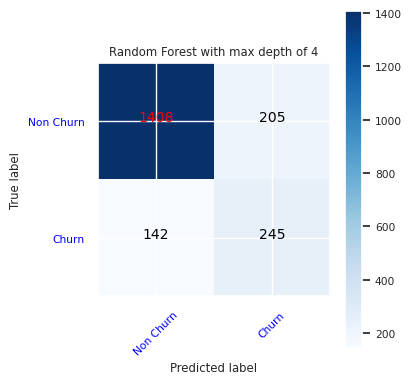

In [ ]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

Create a confusion matrix for the random forest classifier with maximum depth of eight, with six features:

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 65, Finished, Available)

[[1463  150]
 [ 155  232]]


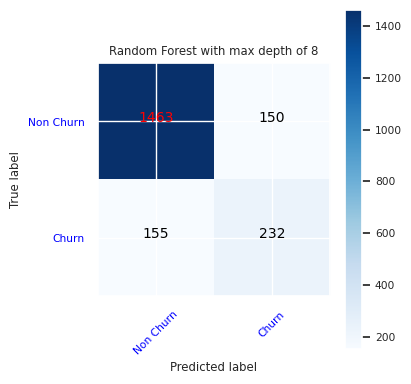

In [ ]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

Create a confusion matrix for LightGBM:

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 66, Finished, Available)

[[1504  109]
 [ 159  228]]


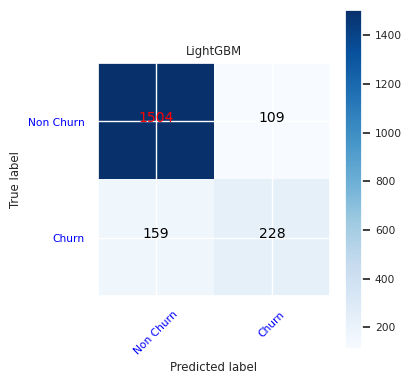

In [ ]:
cfm = confusion_matrix(y_test, y_pred=ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()

### Save results for Power BI

Save the delta frame to the lakehouse, to move the model prediction results to a Power BI visualization.

In [ ]:
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] =ypred_rfc2_sm
df_pred['ypred_lgbm1_sm'] = ypred_lgbm1_sm
table_name = "df_pred_results"
sparkDF=spark.createDataFrame(df_pred)
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")
print(f"Spark DataFrame saved to delta table: {table_name}")

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 67, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


Spark dataframe saved to delta table: df_pred_results


## Step 6: Access visualizations in Power BI

Access your saved table in Power BI:

1. On the left, select **OneLake data hub**
1. Select the lakehouse that you added to this notebook
1. In the **Open this Lakehouse** section, select **Open**
1. On the ribbon, select **New semantic model**. Select `df_pred_results`, and then select **Continue** to create a new Power BI semantic model linked to the predictions
1. Select **New report** from the tools at the top of the semantic models page, to open the Power BI report authoring page

The following screenshot shows some example visualizations. The data panel shows the delta tables and columns to select from a table. After selection of appropriate category (x) and value (y) axis, you can choose the filters and functions - for example, sum or average of the table column.

> [!NOTE]
> In this screenshot, the illustrated example describes the analysis of the saved prediction results in Power BI:

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/PBIviz3.png"  width="100%" height="100%" title="Screenshot shows a Power BI dashboard example.">

However, for a real customer churn use-case, the user might need a more thorough set of requirements of the visualizations to create, based on subject matter expertise, and what the firm and business analytics team and firm have standardized as metrics.

The Power BI report shows that customers who use more than two of the bank products have a higher churn rate. However, few customers had more than two products. (See the plot in the bottom left panel.) The bank should collect more data, but should also investigate other features that correlate with more products.

Bank customers in Germany have a higher churn rate compared to customers in France and Spain. (See the plot in the bottom right panel). Based on the report results, an investigation into the factors that encouraged customers to leave might help.

There are more middle aged customers (between 25-45) and customers between 45-60 tend to exit more.

Finally, customers with lower credit scores would most likely leave the bank for other financial institutions. The bank should explore ways to encourage customers with lower credit scores and account balances to stay with the bank.

In [ ]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, ad4a141b-253f-4dc0-93ea-dbe0e2584e86, 68, Finished, Available)

Full run cost 92 seconds.
